In [1]:
import numpy as np
import pandas as pd
import glob
import emcee
import corner
import scipy.stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from fit_just_early_lc import prep_light_curve

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [3]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype.csv")

In [39]:
### example 

sn = 'ZTF18abauprj'

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 250
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

In [40]:
# alpha_g_samples = samples[:,2]

# params = {'bandwidth': np.logspace(-2.5, 0, 2)}
# grid_alpha_g = GridSearchCV(KernelDensity(rtol=1e-1), params, cv=3)
# alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))
# grid_alpha_g.fit(alpha_g_data)

# print("best bandwidth: {0}".format(grid_alpha_g.best_estimator_.bandwidth))

# # use the best estimator to compute the kernel density estimate
# kde_alpha_g = grid_alpha_g.best_estimator_

In [41]:
# for bandwidth in range()
alpha_g_samples = samples[:,2]
alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

h = 0.9*len(alpha_g_samples)**(-0.2)*np.min([np.std(alpha_g_samples, ddof=1),
           np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349])
print(h)
kde = KernelDensity(rtol=1e-4, bandwidth = h)
kde.fit(alpha_g_data)
# kde.score(alpha_g_data[50000:])

0.005110554853060833


KernelDensity(algorithm='auto', atol=0, bandwidth=0.005110554853060833,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0.0001)

In [42]:
x_grid = np.linspace(0,10,10000)
pdf = kde.score_samples(x_grid.reshape(10000,1))

<IPython.core.display.Javascript object>


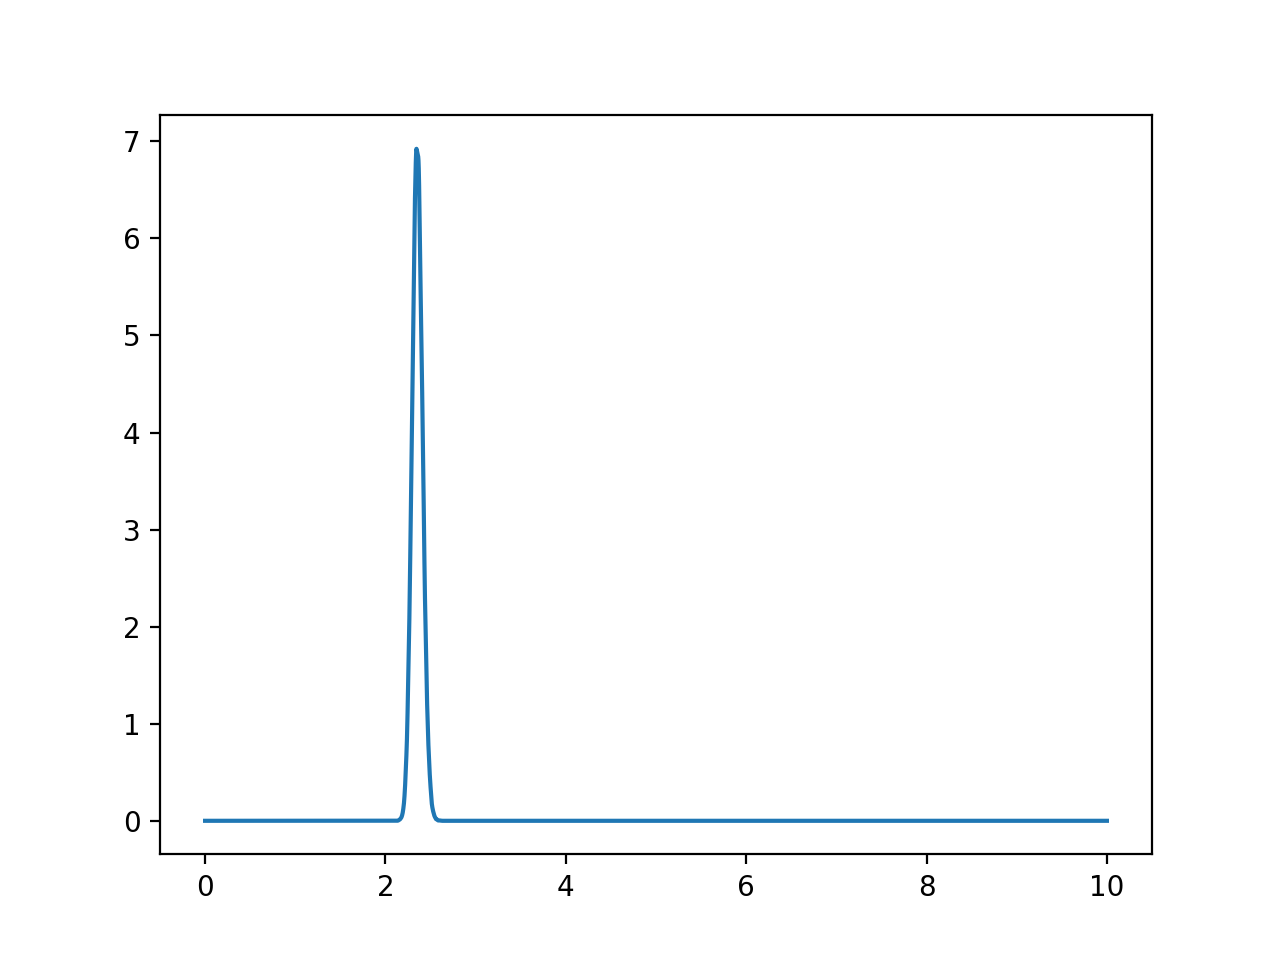

In [44]:
plt.figure()
plt.plot(x_grid, np.exp(pdf))

In [45]:
norm = 1/np.sum(np.exp(pdf)*np.max(x_grid)/len(x_grid))

In [53]:
sn = 'ZTF18aaqffyp'

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 250
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

In [56]:
alpha_g_samples = samples[:,2]

params = {'bandwidth': np.logspace(-2.5, 0, 20)}
grid_alpha_g = GridSearchCV(KernelDensity(rtol=1e-4), params, cv=3, n_jobs=4)
alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))
grid_alpha_g.fit(alpha_g_data)

print("best bandwidth: {0}".format(grid_alpha_g.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde_alpha_g = grid_alpha_g.best_estimator_

best bandwidth: 0.01438449888287663


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [61]:
# for bandwidth in range()
alpha_g_samples = samples[:,2]
alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

h = 0.9*len(alpha_g_samples)**(-0.2)*np.min([np.std(alpha_g_samples, ddof=1),
           np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349])
print(h)
kde = KernelDensity(rtol=1e-4, bandwidth = .4)
kde.fit(alpha_g_data)
# kde.score(alpha_g_data[50000:])

0.02131063484735449


KernelDensity(algorithm='auto', atol=0, bandwidth=0.4, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0.0001)

<IPython.core.display.Javascript object>


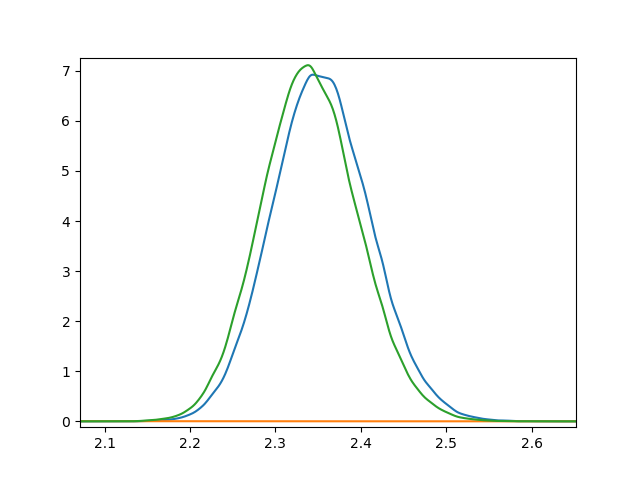

In [64]:
pdf2 = kde.score_samples(x_grid.reshape(10000,1))
norm2 = 1/np.sum(np.exp(pdf2)*np.max(x_grid)/len(x_grid))
plt.figure()
plt.plot(x_grid, np.exp(pdf)*norm)
plt.plot(x_grid, np.exp(pdf2)*norm2)
plt.plot(x_grid, np.exp(pdf)*norm * np.exp(pdf2)*norm2/np.sum(np.exp(pdf)*norm * np.exp(pdf2)*norm2*np.max(x_grid)/len(x_grid)))
# plt.ylim(0,0.2)
# plt.yscale('log')

In [241]:
res = pd.read_csv('results_40percent.csv')

pdf_array_bigh = np.zeros((len(res), 10000))

for sn_num, sn in enumerate(res.ztf_name):
    print(sn)
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(str(sn[2:-1]))
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 250
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
    lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
    
    alpha_g_samples = samples[:,2]
    alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

    h = 0.9*len(alpha_g_samples)**(-0.2)*np.min([np.std(alpha_g_samples, ddof=1),
               np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349])
    print(np.std(alpha_g_samples, ddof=1), np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349)
#     kde = KernelDensity(rtol=1e-4, bandwidth = h)
#     kde.fit(alpha_g_data)
    
#     pdf = kde.score_samples(x_grid.reshape(10000,1))
# #     norm = 1/np.sum(np.exp(pdf)*np.max(x_grid)/len(x_grid))

#     pdf_array_bigh[sn_num] = pdf

b'ZTF18aailmnv'
0.1673233970303444 0.156180471016347
b'ZTF18aansqun'
0.4409235326449479 0.394118031101855
b'ZTF18aaoxryq'
0.20968720487093706 0.2016410458946204
b'ZTF18aapqwyv'
0.41765834460913687 0.38499873343058566
b'ZTF18aapsedq'
0.4998675434226154 0.479892867008815
b'ZTF18aaqcozd'
0.2374534278681944 0.14632669902481957
b'ZTF18aaqcqkv'
0.6448571443740347 0.5357401656560103
b'ZTF18aaqcqvr'
0.10269375314212138 0.09371930132573697
b'ZTF18aaqcugm'
0.15128316805658104 0.14123967009917535
b'ZTF18aaqffyp'
0.29143503082267647 0.20777439275202153
b'ZTF18aaqnrum'
0.6220632119301857 0.43748499048867323
b'ZTF18aaqqoqs'
0.13253212789783872 0.1308667464869748
b'ZTF18aarldnh'
0.2863504340387508 0.2662975675006404
b'ZTF18aarqnje'
0.3107837968780436 0.2999833106969536
b'ZTF18aasdted'
0.033364786073567056 0.032846667326861936
b'ZTF18aasesgl'
0.4616556873273677 0.37946322843285946
b'ZTF18aaslhxt'
0.08391657477786839 0.082214545340197
b'ZTF18aatzygk'
0.7161555191912071 0.5692629364642935
b'ZTF18aauhxce

In [245]:
np.logspace(-2.5, 0, 15)

array([0.00316228, 0.00477058, 0.00719686, 0.01085711, 0.01637894,
       0.02470911, 0.03727594, 0.05623413, 0.08483429, 0.12798022,
       0.19306977, 0.29126327, 0.43939706, 0.66287032, 1.        ])

<IPython.core.display.Javascript object>


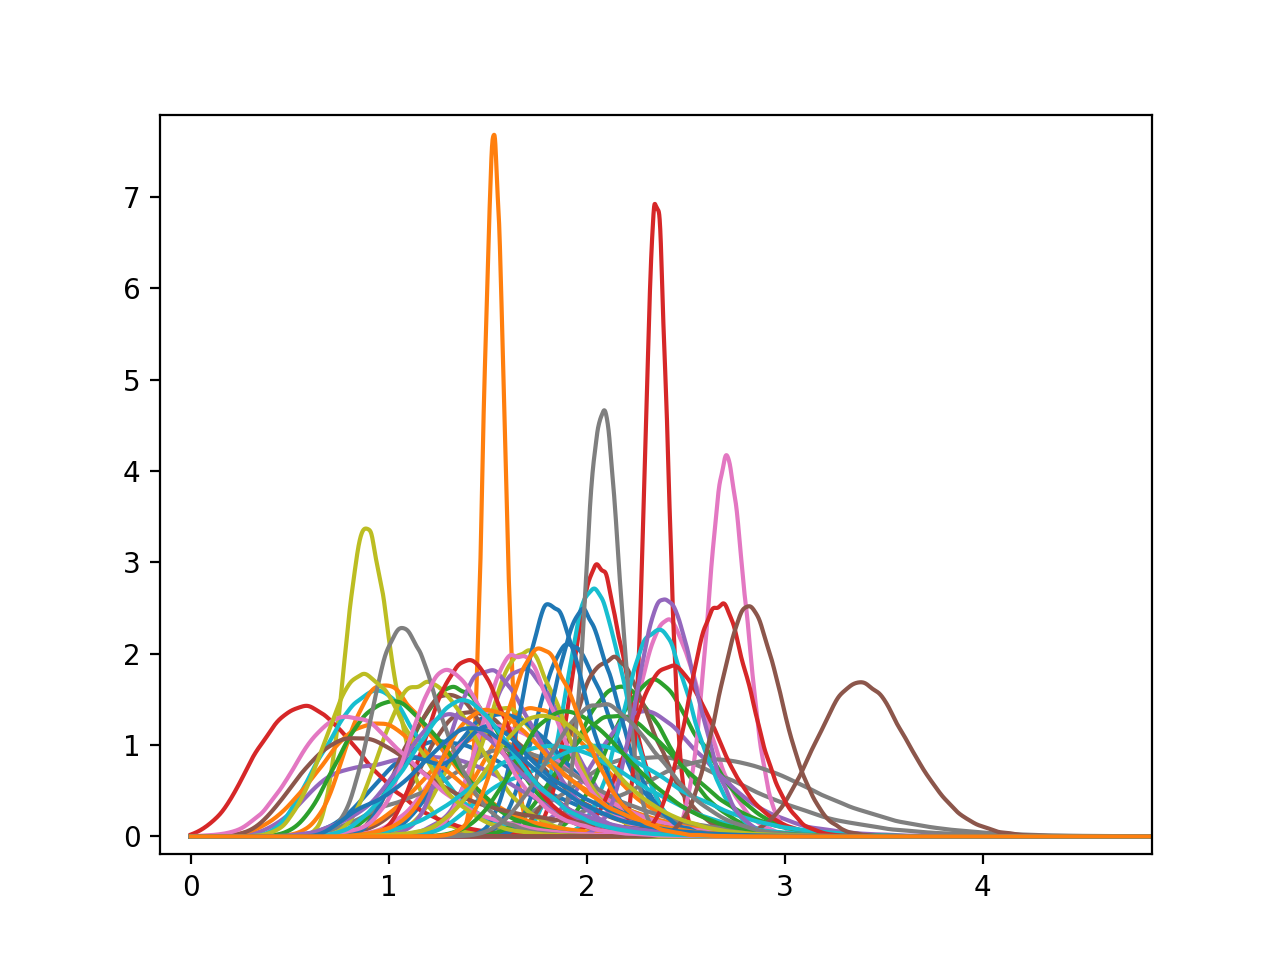

In [203]:
fig, ax = plt.subplots()
for sn_num, kde_pdf in enumerate(pdf_array_bigh):
    if res.final_selection.iloc[sn_num]:
        _ = ax.plot(x_grid, np.exp(kde_pdf))

In [202]:
div_prior = pdf_array_bigh + np.repeat(np.log(10)*x_grid.reshape(1,-1), 127, axis=0)

<IPython.core.display.Javascript object>


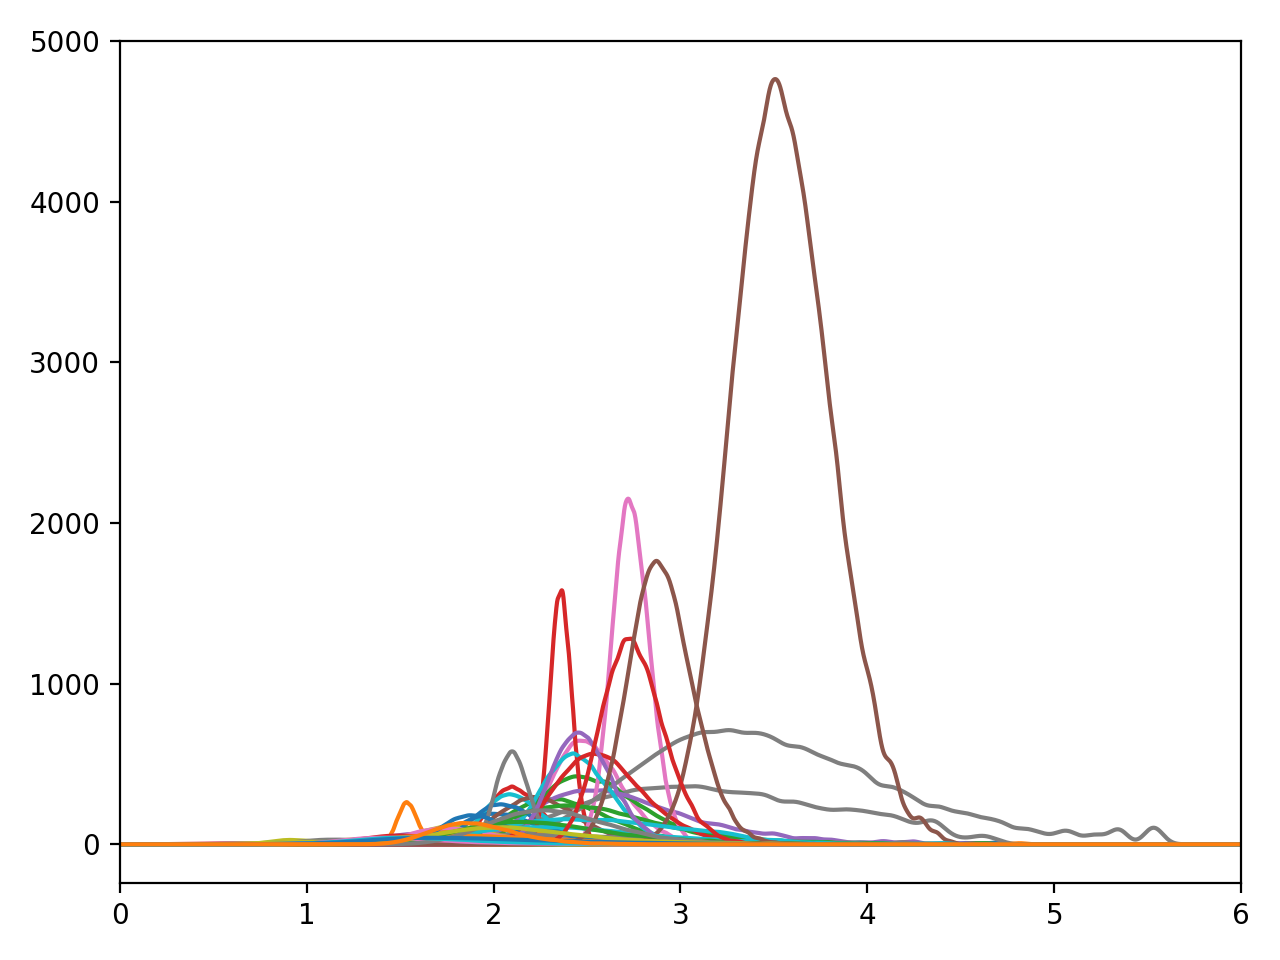

In [205]:
fig, ax = plt.subplots()
for sn_num, kde_pdf in enumerate(div_prior):
    if res.final_selection.iloc[sn_num]:
        _ = ax.plot(x_grid, np.exp(kde_pdf))
ax.set_xlim(0,6)
fig.tight_layout()

In [206]:
norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(x_grid)*np.ptp(x_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(x_grid), axis=1)

<IPython.core.display.Javascript object>


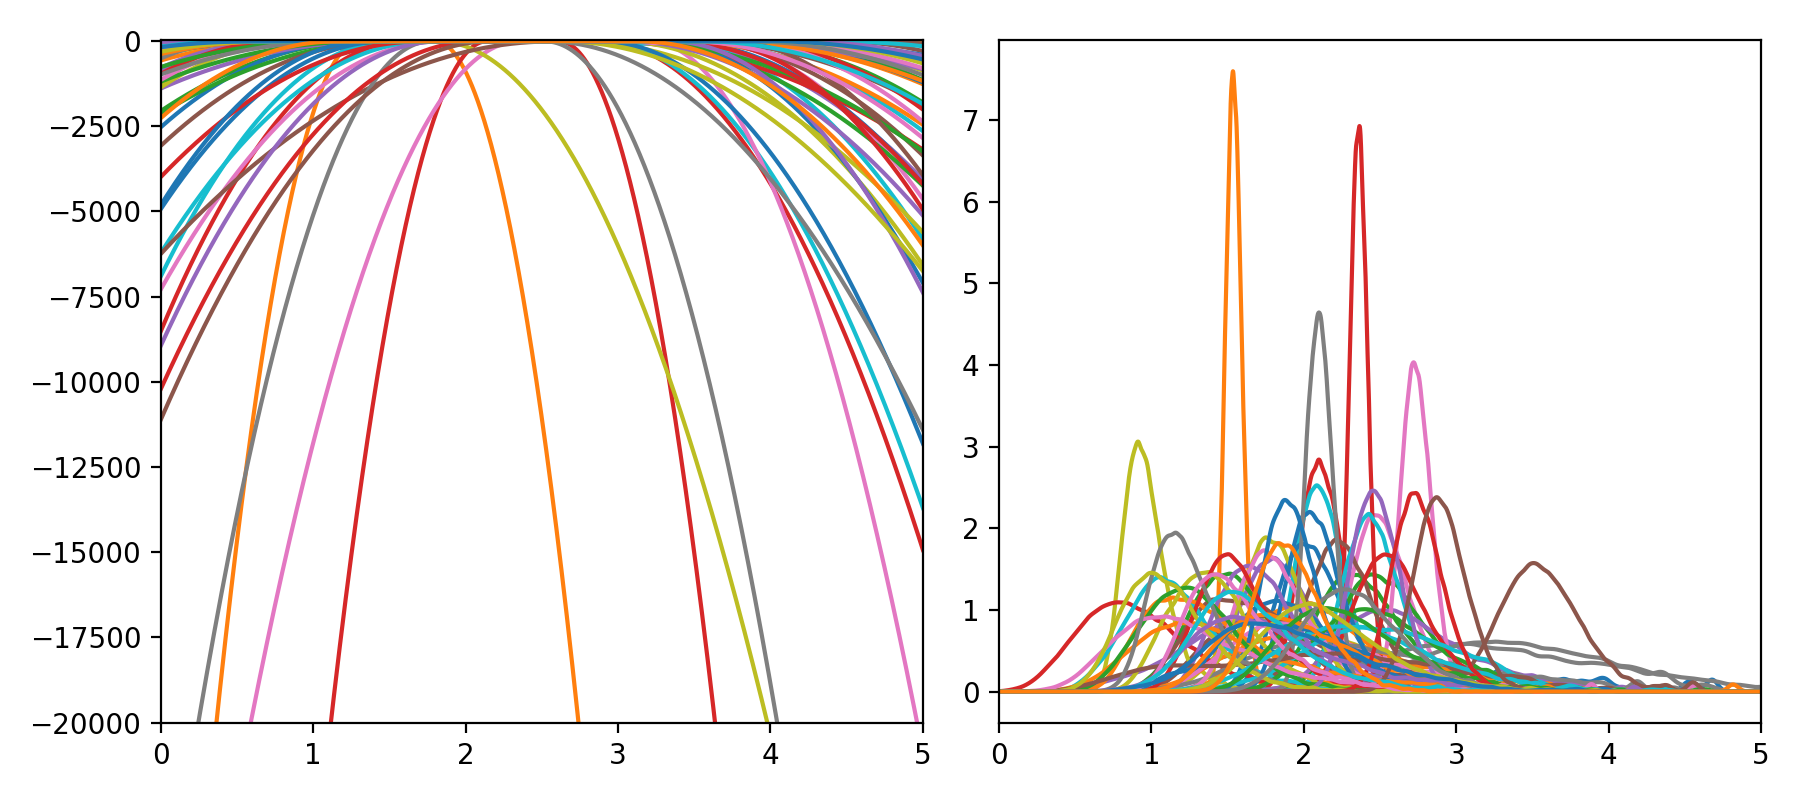

In [222]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(9,4))
for sn_num, kde_pdf in enumerate(norm_pdf_array):
    if res.final_selection.iloc[sn_num]:
        _ = ax.plot(x_grid, kde_pdf)
        _ = ax1.plot(x_grid, np.exp(kde_pdf))

for a in [ax, ax1]:
    a.set_xlim(0,5)
ax.set_ylim(-20000,25)
fig.tight_layout()

In [223]:
good = np.where(res.final_selection.values == 1)
combined = np.sum(norm_pdf_array, axis=0)
combined_good = np.sum(pdf_array_bigh[good], axis=0)
max(combined)

-3106.382041836241

<IPython.core.display.Javascript object>


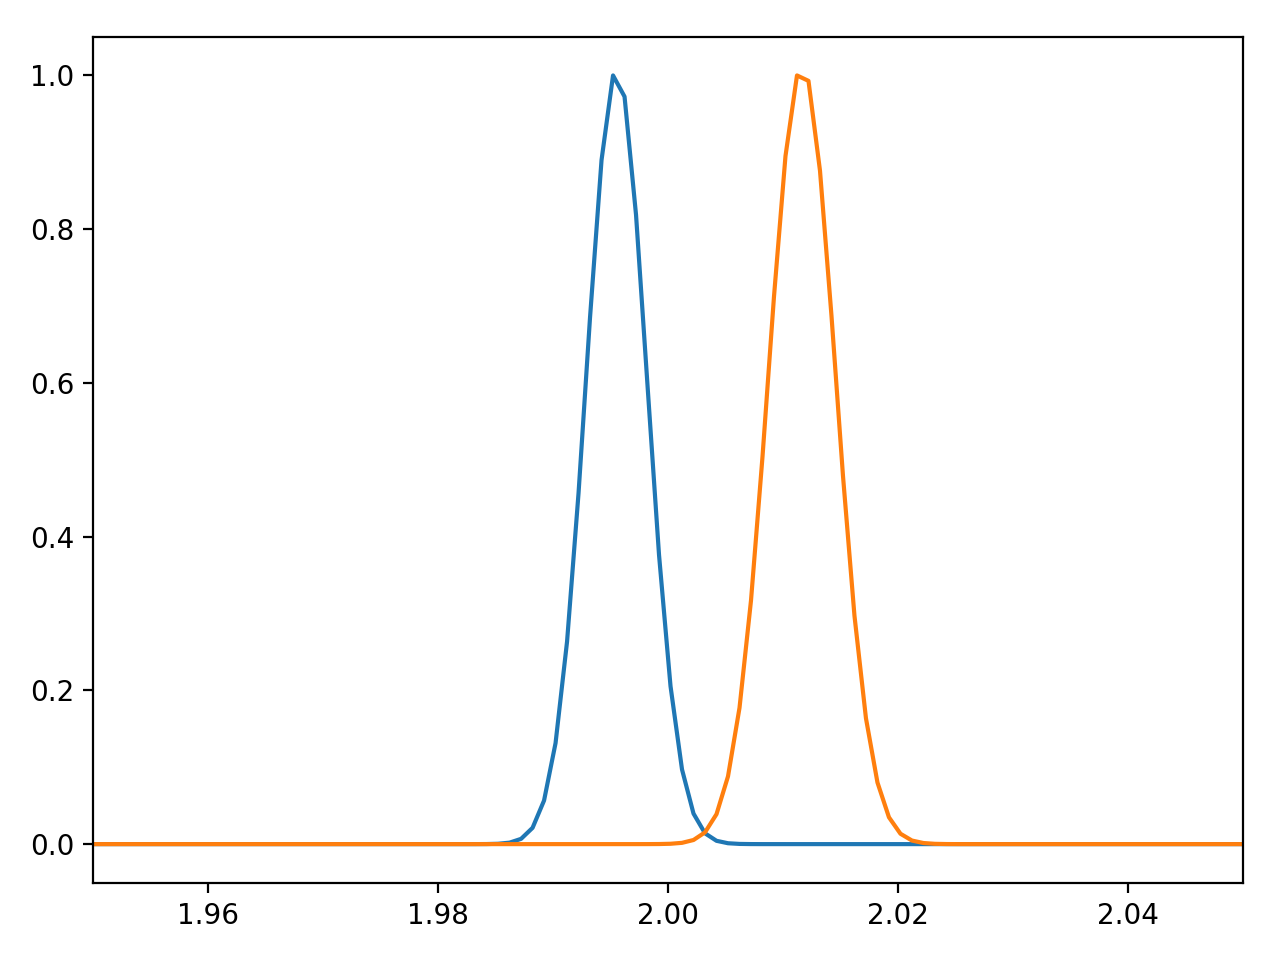

In [229]:
fig, ax  = plt.subplots()
ax.plot(x_grid, np.exp(combined - max(combined)))
ax.plot(x_grid, np.exp(combined_good - max(combined_good)))
ax.set_xlim(1.95, 2.05)
fig.tight_layout()